In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass
from typing import Tuple, Dict, List

%matplotlib inline

In [9]:
data = pd.read_csv('data/test_data.csv', index_col=0)
data.head()

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
sample_1,1561,1572,1688,1711,1869,1924,2020,2208,2327,2556,...,1323,1328,1312,1339,1362,1347,1382,1401,1409,0
sample_2,1832,1894,2071,2129,2326,2432,2567,2826,3064,3383,...,1455,1463,1451,1480,1510,1504,1560,1579,1589,0
sample_3,1851,1932,2110,2182,2374,2488,2622,2887,3127,3457,...,1472,1478,1457,1495,1526,1525,1569,1598,1605,0
sample_4,1926,2011,2202,2280,2498,2620,2769,3055,3331,3695,...,1516,1521,1503,1542,1571,1563,1624,1651,1661,0
sample_5,1856,1924,2094,2165,2357,2470,2604,2877,3120,3450,...,1472,1478,1459,1499,1525,1524,1569,1600,1605,0


In [10]:
class_dict = {'aurora': 0, 'ettore' : 1}
class_col_name = 'class'

In [11]:
spectral_data = torch.from_numpy(data.iloc[:, :-1].to_numpy().astype("float32")).type(torch.float32)
spectral_data

tensor([[1561., 1572., 1688.,  ..., 1382., 1401., 1409.],
        [1832., 1894., 2071.,  ..., 1560., 1579., 1589.],
        [1851., 1932., 2110.,  ..., 1569., 1598., 1605.],
        ...,
        [1497., 1495., 1602.,  ..., 1339., 1351., 1361.],
        [1557., 1563., 1683.,  ..., 1383., 1402., 1410.],
        [1518., 1514., 1629.,  ..., 1354., 1371., 1375.]])

In [12]:
labels = torch.from_numpy(data[class_col_name].to_numpy().astype(
            "uint8")).type(torch.uint8)
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1], dtype=torch.uint8)

In [22]:
from torch.utils.data import Dataset
class NIRSpectralData(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, root_dir: str, label_column_name: str, class_dict: dict = None, transform=None) -> None:

        # setup root_dir to .csv file
        self.root_dir = root_dir
        # setup label columns name
        self.label_col_name = label_column_name
        # setup data and labels
        self.df = pd.read_csv(root_dir, index_col=0)
        
        self.data = torch.from_numpy(
            self.df.iloc[:, :-1].to_numpy().astype("float32")).type(torch.float32)
        
        self.labels = torch.from_numpy(self.df[self.label_col_name].to_numpy().astype("uint8")).type(torch.uint8)

        # setup class dictionary
        if class_dict:
            self.class_to_idx = class_dict
            self.classes = list(class_dict.keys())
        else:
            self.class_to_idx = {
                i: i for i in range(len(self.labels.unique()))}
            self.classes = list(self.class_to_idx.keys())
        # Setup transforms
        self.transform = transform

    # override __len__ and __getitem__ methods
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        spectral_data = self.data[index]
        class_idx = self.labels[index].item()

        # Transform if necessary
        if self.transform:
            # return data, label (X, y)
            return self.transform(spectral_data), class_idx
        else:
            return spectral_data, class_idx  # return data, label (X, y)


In [23]:
dataset = NIRSpectralData(root_dir='data/test_data.csv', label_column_name=class_col_name, class_dict=class_dict)

In [24]:
data, class_idx = dataset[0] 

In [26]:
len(dataset)

27

In [32]:
classes = dataset.classes
classes

['aurora', 'ettore']

In [25]:
len(data), class_idx

(125, 0)

In [155]:

@dataclass
class NIRDataGenerator():
    df: pd.DataFrame  # dataframe with columns 0:-1 as spectra data with different wavelenghts and last column as class label
    batch_size: int  # number of samples per batch
    class_col_name: str  # name of the column containing the class label

    weighted_sum: bool = True
    roll: bool = True
    # number of shift (needs to be multiplied with nm resolution of the spectral data to obtain the real shift)
    roll_factor: int = 12

    slope: bool = True
    slope_factor: float = 0.2

    noise: bool = True
    noise_range: tuple = (80, 100)

    # if True, labels are sparse (es 0,1,2,...) , otherwise categorical (with one-hot encoding, es: [1,0,0], [0,1,0], [0,0,1], ...])
    sparse_labels: bool = True

    def __post_init__(self):
        # transform to numpy for performance reasons
        self.samples = self.df.iloc[:, :-1].to_numpy().astype("float32")
        self.labels = self.df[self.class_col_name].to_numpy().astype("uint8")
        self.columns = self.df.columns[:-1]

    def __len__(self):
        return int(len(self.df) // self.batch_size)

    def __getitem__(self, index):
        # selection of mini-batch
        BOTTOM = index * self.batch_size
        TOP = (index + 1) * self.batch_size
        batch_samples = self.samples[BOTTOM:TOP]
        batch_labels = self.labels[BOTTOM:TOP].reshape((self.batch_size, 1))

        batch_samples = self._augmentation(batch_samples, batch_labels)
        batch_labels = batch_labels.reshape((self.batch_size,))

        # in case of categorical crossentropy loss, labels are translated
        # form sparse to categorical
        if not self.sparse_labels:
            # TODO: to implement
            pass
        
        data = pd.DataFrame(batch_samples, columns=self.columns)
        data['class'] = batch_labels
        return (
            data
        )
    
    def augment_all_once(self):
        # selection of all data
        data_len = len(self.df)
        batch_samples = self.samples
        batch_labels = self.labels.reshape((data_len, 1))
        batch_samples = self._augmentation(batch_samples, batch_labels, batch_size=data_len)
        batch_labels = batch_labels.reshape((data_len,))

        # in case of categorical crossentropy loss, labels are translated
        # form sparse to categorical
        if not self.sparse_labels:
            # TODO: to implement
            pass
        
        data = pd.DataFrame(batch_samples, columns=self.columns)
        data['class'] = batch_labels
        
        return data
    
    def augment_n_times(self, iterations: int = 10):
        
        print(f"Augmenting {iterations} times...")
        data_df_list = []
        
        for _ in range(iterations):
            data = self.augment_all_once()
            data_df_list.append(data)
        
        augmented_df = pd.concat(data_df_list)
        
        print(f"Done!\nDataset is now composed of {len(augmented_df)} samples")
        
        return augmented_df

    def _augmentation(self, batch_samples, batch_labels, batch_size=None):
        """Compute data augmentation on 'batch_samples', applying 
        weighted sum + roll(horizontal shift) + baseline noise + adittive white gaussian noise

        Args:
            batch_samples (np.array): Batch of spectra (1d array)
            batch_labels (np.array): Batch of label, number that are class identifier

        Returns:
            np.array: Batch of augmented data
        """
        
        if batch_size is None:
            batch_size = self.batch_size
        else:
            batch_size = batch_size

        if self.weighted_sum:
            alpha = np.random.rand(batch_size)

            other_samples = np.apply_along_axis(
                self._get_random_sample_from_class, 1, batch_labels
            ).reshape(batch_size, batch_samples.shape[1])

            if self.roll:
                other_samples = np.apply_along_axis(
                    self._random_roll, 1, other_samples)

            batch_samples = (
                np.multiply(
                    batch_samples -
                    other_samples, alpha.reshape(batch_size, 1)
                )
                + other_samples
            )

        if self.slope:
            batch_samples = np.apply_along_axis(
                lambda x: self._produce_background_baseline(
                    x, batch_samples.shape[1]),
                1,
                batch_samples,
            )

        if self.noise:
            batch_samples = np.apply_along_axis(
                self._random_noise, 1, batch_samples)

        return batch_samples

    def _get_random_sample_from_class(self, label):
        """Extract a random sample from the datas marked as 'label'

        Args:
            label (int): Number that describe the class identifier of data to select

        Returns:
            np.array: Random sample of the 'label' class
        """
        class_indexes = np.where(self.labels == label)[0]
        CLASS_INDEX = np.random.choice(class_indexes, 1)[0]

        return self.samples[CLASS_INDEX: CLASS_INDEX + 1]

    def _random_noise(self, arr):
        """Apply adittive white gaussian noise to 'arr' of magnitued 'noise_range'

        Args:
            arr (np.array): Sample to wich apply the noise

        Returns:
            np.array: Noise 'arr'
        """
        rnd_snr = random.randint(self.noise_range[0], self.noise_range[1])
        NOISE_FACTOR = 1 / (10 ** (rnd_snr / 10))

        return arr + np.random.normal(0, NOISE_FACTOR, len(arr))

    def _random_roll(self, arr):
        """Apply random roll (numpy way to say horizontal shift) to 'arr' of magnitude 'roll_factor'

        Args:
            arr (np.array): Sample to wich apply the roll

        Returns:
            np.array: Random rolled sample
        """

        SHIFT_FACTOR = self.roll_factor
        random_shift = random.randint(-1 * SHIFT_FACTOR, SHIFT_FACTOR)

        rolled = np.roll(arr, random_shift)
        padded = (
            np.pad(rolled[random_shift:], (random_shift, 0), "edge")
            if random_shift >= 0
            else np.pad(rolled[:random_shift], (0, abs(random_shift)), "edge")
        )

        return padded

    def _produce_background_baseline(self, arr, steps):
        """Apply a random baseline noise to 'arr' of magnitude 'slope_factor' 

        Args:
            arr (np.array): Spectrum to wich apply the baseline noise
            steps (int): Length of the 'arr' argument

        Returns:
            np.array: Noised spectrum
        """

        SLOPE = random.triangular(-1 * self.slope_factor, self.slope_factor)
        line = (
            np.linspace(abs(SLOPE), 0, steps)
            if SLOPE < 0
            else np.linspace(0, SLOPE, steps)
        )

        alpha = random.random()

        return arr * alpha + line * (1 - alpha)


In [156]:
batch_size = 3
data = pd.read_csv('data/test_data.csv', index_col=0)
aug_data = NIRDataGenerator(df=data, batch_size=batch_size, class_col_name="class")

In [157]:
len(data)

27

In [158]:
df_batch = aug_data[0]
df_batch

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
0,1379.916164,1413.053106,1529.269727,1568.210879,1709.644777,1778.558299,1871.885683,2059.163758,2207.632199,2434.671231,...,1126.439872,1130.883063,1116.749301,1143.983326,1163.740608,1157.657501,1190.039923,1210.420318,1215.568522,0
1,916.479676,953.361643,1026.049747,1087.746882,1183.999724,1270.162312,1332.566750,1405.027493,1470.323929,1558.197935,...,670.992177,672.092074,677.267709,690.419557,699.811436,698.101423,714.060023,719.474450,722.324079,0
2,386.543178,404.144912,437.646158,454.349507,491.460263,514.246299,542.838941,594.070068,643.038240,707.829142,...,311.460202,312.002587,308.754622,316.455597,321.792051,322.330666,330.841491,336.597562,337.940150,0


In [159]:
batch_size = 3
data = pd.read_csv('data/test_data.csv', index_col=0)
NIR_DATA = NIRDataGenerator(df=data, batch_size=batch_size, class_col_name="class")
aug_data = NIR_DATA.augment_all()

In [160]:
aug_data

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
0,838.315948,841.781789,878.337408,885.584937,935.376467,952.708500,982.961304,1042.207055,1079.708095,1146.489389,...,720.382748,717.509078,714.573382,717.930387,736.650794,717.874555,746.698440,739.807688,742.093966,0
1,806.479998,832.145217,905.415208,929.424608,1010.973689,1054.852908,1110.736807,1217.951069,1316.472286,1448.523821,...,644.049390,647.948968,641.186897,653.872347,666.878925,663.838274,687.267304,694.575516,699.921849,0
2,1217.981192,1336.522328,1401.020589,1402.070148,1410.490611,1415.300334,1455.624839,1495.873996,1584.134059,1645.715662,...,673.063138,673.599744,671.719101,675.120594,677.895393,677.805305,681.743964,684.339708,684.965842,0
3,1675.211994,1736.787895,1890.162068,1938.686813,2107.123319,2198.833623,2272.561197,2429.348336,2560.792644,2772.356300,...,1330.101941,1346.122516,1338.016029,1362.055123,1377.273917,1373.075625,1405.087574,1419.256795,1424.504654,0
4,505.404193,522.671444,571.186886,587.579341,641.667270,671.083858,708.227477,780.004731,845.707370,933.910554,...,401.243823,403.381141,399.848798,408.190301,416.321308,414.829979,429.894255,435.514299,438.105212,0
5,769.188910,781.456337,792.877390,835.934736,858.729056,918.102736,941.419287,996.645195,1081.133386,1138.544197,...,653.130801,654.421138,651.985417,652.169784,666.068406,671.826120,670.158708,685.946622,690.905999,0
6,698.542179,682.126667,720.412134,709.376375,759.700469,764.056900,784.794491,837.053144,844.408240,898.757831,...,572.372246,574.004288,565.435141,576.452277,585.429174,573.187599,586.244973,589.101157,588.692961,0
7,1531.404859,1521.872810,1569.532707,1569.947083,1625.895669,1642.472987,1668.996730,1736.135045,1805.918013,1961.189666,...,1262.234893,1260.821543,1248.452374,1278.025371,1264.998024,1287.184958,1281.128537,1283.933989,1290.585954,0
8,1418.888279,1404.412093,1496.957239,1512.453639,1638.434927,1688.059236,1753.358040,1912.279578,1995.356598,2158.362458,...,1222.118638,1223.628813,1206.887375,1228.046304,1255.361893,1240.935417,1269.565299,1282.228352,1291.628447,0
9,1083.240254,1072.387988,1113.551632,1104.138538,1159.773437,1174.838310,1187.306809,1271.946464,1275.556812,1359.421531,...,892.656319,896.808081,883.835125,900.441228,909.263368,896.290412,911.858654,913.415762,917.567524,0


In [163]:
iterated_aug_data = NIR_DATA.augment_n_times(iterations=100)
len(iterated_aug_data)

Augmenting 100 times...
Done!
Dataset is now composed of 2700 samples


2700

In [164]:
iterated_aug_data.to_csv('data/test_data_augmented.csv')

In [167]:
aug_data = pd.read_csv('data/test_data_augmented.csv', index_col=0)
aug_data.head()

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
0,86.685012,86.974744,90.041349,90.648437,94.825791,96.279165,98.816841,103.787588,106.933533,112.988582,...,74.623752,75.244389,73.228919,74.492575,75.681044,74.701787,75.901624,75.729748,77.439492,0
1,872.052427,891.782749,941.366471,967.368803,1023.719221,1074.906744,1114.166399,1210.630268,1296.359732,1402.418872,...,632.358080,634.771492,631.151414,639.899989,648.950239,647.140208,664.033994,669.765824,672.782585,0
2,1505.832410,1573.918066,1672.569603,1818.844259,1973.332656,2157.532601,2255.410251,2294.560564,2326.600294,2368.833606,...,1020.658128,1018.492287,1044.285573,1060.235002,1070.383972,1070.224016,1077.242541,1081.868239,1082.984457,0
3,132.859219,136.565701,144.894668,148.295891,157.802283,163.122273,169.619689,182.091449,194.127125,210.000335,...,109.093768,109.977448,107.194671,109.660915,111.657783,110.576235,113.569050,114.047088,116.081024,0
4,1728.131546,1818.370829,2000.034033,2155.420635,2381.411615,2487.381070,2509.977980,2559.289519,2601.669668,2717.024607,...,1109.086477,1141.354217,1151.000012,1164.644121,1170.211475,1169.997701,1179.633257,1186.271191,1187.342112,0


In [166]:
original_data = pd.read_csv('data/test_data.csv', index_col=0)
original_data.head()

,859,867,876,884,892,900,909,917,925,934,...,1814,1822,1830,1838,1846,1854,1863,1871,1879,class
sample_1,1561,1572,1688,1711,1869,1924,2020,2208,2327,2556,...,1323,1328,1312,1339,1362,1347,1382,1401,1409,0
sample_2,1832,1894,2071,2129,2326,2432,2567,2826,3064,3383,...,1455,1463,1451,1480,1510,1504,1560,1579,1589,0
sample_3,1851,1932,2110,2182,2374,2488,2622,2887,3127,3457,...,1472,1478,1457,1495,1526,1525,1569,1598,1605,0
sample_4,1926,2011,2202,2280,2498,2620,2769,3055,3331,3695,...,1516,1521,1503,1542,1571,1563,1624,1651,1661,0
sample_5,1856,1924,2094,2165,2357,2470,2604,2877,3120,3450,...,1472,1478,1459,1499,1525,1524,1569,1600,1605,0


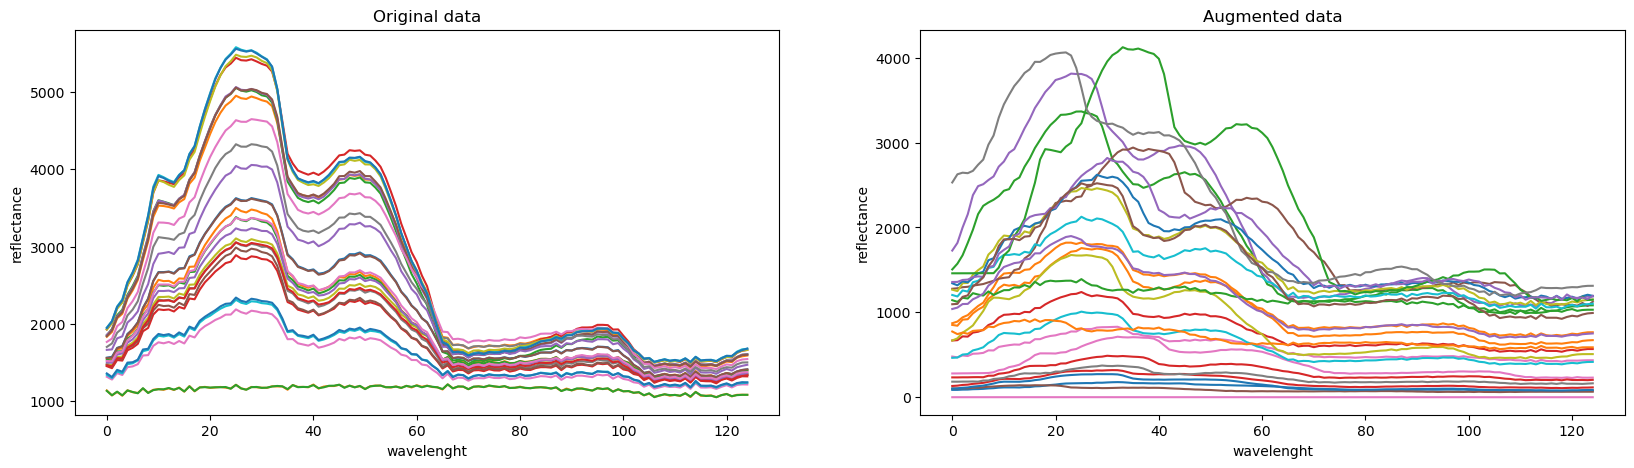

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
X_original = original_data.iloc[:,:-1].to_numpy()
X_augmented = aug_data.iloc[:len(original_data),:-1].to_numpy()

plt_original = ax[0]

for i in range(X_original.shape[0]):
    plt_original.plot(X_original[i,:])

plt_original.set_ylabel('reflectance')
plt_original.set_xlabel('wavelenght')
plt_original.set_title("Original data")

plt_augmented = ax[1]

for i in range(X_augmented.shape[0]):
    plt_augmented.plot(X_augmented[i,:])
plt_augmented.set_ylabel('reflectance')
plt_augmented.set_xlabel('wavelenght')
plt_augmented.set_title("Augmented data")

plt.show()